Downloading Dataset


In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("arunrk7/surface-crack-detection")

print("Path to dataset files:", path)

c:\Users\sreeh\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\sreeh\.cache\kagglehub\datasets\arunrk7\surface-crack-detection\versions\1


Saperating 1000 images

In [1]:
import shutil
from pathlib import Path
from tqdm import tqdm

# --- 1. CONFIGURE YOUR FOLDERS AND SETTINGS HERE ---

# The folder where your 20,000 original images are located.
source_folder = Path("Positive") 

# The new folder where you want the first 1000 images to be copied.
destination_folder = Path("Dataset_1000/")

# The number of images you want to select.
num_to_select = 1000

# You can add other extensions if needed.
image_extensions = [".jpg", ".jpeg", ".png"]


# --- 2. THE SCRIPT ---
try:
    # Create the destination folder if it doesn't exist
    destination_folder.mkdir(parents=True, exist_ok=True)

    print(f"Searching for images in: {source_folder}")
    all_images = [f for f in source_folder.glob("*") if f.suffix.lower() in image_extensions]
    
    # --- Sort the files alphabetically to get the "first" ones ---
    all_images.sort()

    if not all_images:
        print("Error: No images found in the source folder.")
    else:
        print(f"Found {len(all_images)} total images.")
        
        # Ensure we don't try to select more images than are available
        if len(all_images) < num_to_select:
            print(f"Warning: Only {len(all_images)} images available. Selecting all of them.")
            num_to_select = len(all_images)

        # Select the first N images from the sorted list
        files_to_copy = all_images[:num_to_select]

        print(f"Copying the first {num_to_select} images to: {destination_folder}")

        # Copy each selected file to the destination with a progress bar
        for image_path in tqdm(files_to_copy, desc="Copying images"):
            shutil.copy(image_path, destination_folder)

        print("\n✅ Done. All files copied successfully.")

except FileNotFoundError:
    print(f"Error: The source folder was not found at '{source_folder}'")
except Exception as e:
    print(f"An error occurred: {e}")

Searching for images in: Positive
Found 20000 total images.
Copying the first 1000 images to: Dataset_1000


Copying images: 100%|██████████| 1000/1000 [00:05<00:00, 188.93it/s]


✅ Done. All files copied successfully.


Adding Blur

In [2]:
from pathlib import Path
from PIL import Image, ImageFilter
from tqdm import tqdm

# --- 1. CONFIGURE YOUR SETTINGS HERE ---

# Folder with your 500 clean, original images.
source_folder = Path("Dataset_1000/")

# Folder where the new blurred images will be saved (this will be part of trainA).
destination_folder = Path("blur/")

# Adjust the blur intensity. Higher numbers mean more blur. Try values between 2 and 8.
blur_radius = 5

# --- 2. THE SCRIPT ---

try:
    # Create the destination folder if it doesn't exist
    destination_folder.mkdir(parents=True, exist_ok=True)

    # Get a list of all image files in the source folder
    image_files = list(source_folder.glob("*.jpg")) + \
                  list(source_folder.glob("*.jpeg")) + \
                  list(source_folder.glob("*.png"))

    if not image_files:
        print(f"Error: No images found in '{source_folder}'")
    else:
        print(f"Found {len(image_files)} images. Starting blur process...")

        # Loop through all images and show a progress bar
        for image_path in tqdm(image_files, desc="Applying blur"):
            try:
                # Open the image
                with Image.open(image_path) as img:
                    # Apply a Gaussian blur filter
                    blurred_img = img.filter(ImageFilter.GaussianBlur(radius=blur_radius))
                    
                    # Construct the new filename/path for the blurred image
                   
                    save_path = destination_folder / f"blur_{image_path.name}"
                    # Save the blurred image
                    blurred_img.save(save_path)
            except Exception as e:
                print(f"\nCould not process {image_path.name}: {e}")

        print(f"\n✅ Done. All blurred images saved to '{destination_folder}'.")

except FileNotFoundError:
    print(f"Error: Source folder not found at '{source_folder}'")

Found 1000 images. Starting blur process...


Applying blur: 100%|██████████| 1000/1000 [00:04<00:00, 247.85it/s]


✅ Done. All blurred images saved to 'blur'.


Remove Blur Using Cycle Gan Model

In [2]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import torch.nn as nn
from pathlib import Path
from tqdm import tqdm

# ==============================================================================
# ===== 1. DEFINE THE MODEL ARCHITECTURE (Same as before) ======================
# ==============================================================================

class ResnetGenerator(nn.Module):
    """Resnet-based generator that consists of Resnet blocks between a few downsampling/upsampling operations."""
    def __init__(self, input_nc=3, output_nc=3, ngf=64, norm_layer=nn.InstanceNorm2d, use_dropout=False, n_blocks=9, padding_type='reflect'):
        super(ResnetGenerator, self).__init__()
        use_bias = norm_layer == nn.InstanceNorm2d
        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=use_bias),
                 norm_layer(ngf),
                 nn.ReLU(True)]
        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=use_bias),
                      norm_layer(ngf * mult * 2),
                      nn.ReLU(True)]
        mult = 2 ** n_downsampling
        for i in range(n_blocks):
            model += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]
        for i in range(n_downsampling):
            mult = 2 ** (n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2), kernel_size=3, stride=2, padding=1, output_padding=1, bias=use_bias),
                      norm_layer(int(ngf * mult / 2)),
                      nn.ReLU(True)]
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]
        self.model = nn.Sequential(*model)

    def forward(self, input):
        return self.model(input)

class ResnetBlock(nn.Module):
    """Define a Resnet block"""
    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim), nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim)]
        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)  # add skip connections
        return out

# ===============================================================
# ================== 2. LOAD AND USE THE MODEL ==================
# ===============================================================

# --- Define Paths and Parameters ---
model_path = "50_net_G.pth"
input_folder = Path("blur/")  # <--- SET YOUR INPUT FOLDER
output_folder = Path("unblurred_results/") # <--- SET YOUR OUTPUT FOLDER
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- Create Model and Load Weights ---
print("Loading model...")
model = ResnetGenerator(n_blocks=9, norm_layer=nn.InstanceNorm2d).to(DEVICE)
model.load_state_dict(torch.load(model_path, map_location=DEVICE))
model.eval() # Set model to evaluation mode
print("Model loaded successfully.")

# --- Define Image Pre-processing ---
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) # Normalize to [-1, 1]
])

# --- Process the Entire Folder ---
output_folder.mkdir(parents=True, exist_ok=True)
image_files = list(input_folder.glob("*.jpg")) + list(input_folder.glob("*.png"))

print(f"Found {len(image_files)} images to process.")

for image_path in tqdm(image_files, desc="Unblurring images"):
    try:
        # Load and transform the input image
        input_image = Image.open(image_path).convert("RGB")
        input_tensor = transform(input_image).unsqueeze(0).to(DEVICE)

        # Run inference
        with torch.no_grad():
            output_tensor = model(input_tensor)

        # Post-process and Save the Output Image
        output_tensor = (output_tensor * 0.5) + 0.5
        output_image = transforms.ToPILImage()(output_tensor.squeeze(0).cpu())
        
        # Save with the same name in the output folder
        output_image.save(output_folder / image_path.name)
    except Exception as e:
        print(f"Error processing {image_path.name}: {e}")

print(f"\n✅ Processing complete. All restored images saved to '{output_folder}'.")

Loading model...
Model loaded successfully.
Found 1000 images to process.


Unblurring images: 100%|██████████| 1000/1000 [00:29<00:00, 34.07it/s]


✅ Processing complete. All restored images saved to 'unblurred_results'.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd
from pathlib import Path
from skimage.morphology import skeletonize
from scipy.ndimage import distance_transform_edt
from tqdm import tqdm

# ===============================================================
# ===== 1. YOUR PROFESSOR'S FUNCTIONS ===========================
# ===============================================================

def classify_crack_width(width_mm):
    if width_mm <= 1.0: return "Light Crack"
    elif width_mm <= 2.0: return "Medium Crack"
    else: return "Heavy Crack"

def crack_width_measure(binary_image, pixel_size_mm=0.01, display_results=False):
    if binary_image.dtype != np.uint8: binary_image = binary_image.astype(np.uint8)
    if np.sum(binary_image) == 0: return np.array([0]), 0
    skeleton = skeletonize(binary_image > 0)
    distance = distance_transform_edt(binary_image)
    crack_widths_pixels = distance[skeleton]
    if len(crack_widths_pixels) == 0: return np.array([0]), 0
    crack_widths_pixels = crack_widths_pixels * 2
    crack_widths_mm = crack_widths_pixels * pixel_size_mm
    return crack_widths_mm, np.max(crack_widths_mm)

def analyse_crack_image(image_path, pixel_size_mm=0.01, display_results=False):
    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    if img is None: return np.array([0]), 0, "Error"
    _, binary_image = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)
    crack_widths_mm, max_crack_width_mm = crack_width_measure(binary_image, pixel_size_mm, display_results)
    classification = classify_crack_width(max_crack_width_mm)
    return crack_widths_mm, max_crack_width_mm, classification

def analyse_folder(folder_path, pixel_size_mm=0.01, display_results=False):
    results = {}
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    for filename in tqdm(image_files, desc=f"Analyzing {Path(folder_path).name}"):
        image_path = os.path.join(folder_path, filename)
        _, max_width, classification = analyse_crack_image(image_path, pixel_size_mm, display_results)
        results[filename] = (max_width, classification)
    return results

# ===============================================================
# =========== 2. DEFINE YOUR FOLDERS AND RUN ANALYSIS ===========
# ===============================================================

# --- Define Your Folders for the Blur analysis ---
folder_clean = Path("Dataset_1000/")
folder_augmented = Path("blur/")
folder_restored = Path("unblurred_results/")

# --- Run Analysis on Each Folder ---
results_clean = analyse_folder(str(folder_clean))
results_augmented = analyse_folder(str(folder_augmented))
results_restored = analyse_folder(str(folder_restored))

# ===============================================================
# ========= 3. COMBINE AND COMPARE RESULTS (BLUR ONLY) ==========
# ===============================================================
comparison_data = []

# Loop through the clean images as the ground truth
for clean_filename, (clean_width, clean_class) in results_clean.items():
    
    # --- THIS IS THE CORRECTED LOGIC ---
    # Construct the expected filename for the augmented and restored images
    aug_filename = f"blur_{clean_filename}"
    
    # Get data using the correct prefixed key
    aug_width, aug_class = results_augmented.get(aug_filename, (None, "N/A"))
    # Restored file also has the prefix and could be .png or .jpg
    res_filename_jpg = aug_filename
    res_filename_png = Path(aug_filename).with_suffix('.png').name
    res_width, res_class = results_restored.get(res_filename_jpg, results_restored.get(res_filename_png, (None, "N/A")))
    
    comparison_data.append({
        'filename': Path(clean_filename).stem,
        'clean_width_mm': clean_width,
        'clean_class': clean_class,
        'blurred_width_mm': aug_width,
        'blurred_class': aug_class,
        'restored_width_mm': res_width,
        'restored_class': res_class
    })

# Create a final DataFrame
df_comparison = pd.DataFrame(comparison_data)

print("\n--- Final Blur Comparison Report ---")
print(df_comparison.head())

# Save the final report to a CSV
df_comparison.to_csv("blur_crack_width_comparison.csv", index=False)
print("\n✅ Final blur comparison report saved to 'blur_crack_width_comparison.csv'")

Analyzing unblurred_results: 100%|██████████| 1000/1000 [00:03<00:00, 300.48it/s]



--- Final Blur Comparison Report ---
  filename  clean_width_mm  clean_class  blurred_width_mm blurred_class  \
0    00001        0.233238  Light Crack          0.322490   Light Crack   
1    00002        0.160000  Light Crack          0.189737   Light Crack   
2    00003        0.200000  Light Crack          0.277849   Light Crack   
3    00004        0.216333  Light Crack          0.223607   Light Crack   
4    00005        0.160000  Light Crack          0.178885   Light Crack   

   restored_width_mm restored_class  
0           0.223607    Light Crack  
1           0.180000    Light Crack  
2           0.200998    Light Crack  
3           0.240000    Light Crack  
4           0.184391    Light Crack  

✅ Final blur comparison report saved to 'blur_crack_width_comparison.csv'


In [2]:
import pandas as pd

# Load your results
df = pd.read_csv("blur.csv")

# Calculate and print the average of the key columns
print("--- Average Crack Widths (in mm) ---")
print(df[['clean_width_mm', 'blurred_width_mm', 'restored_width_mm']].mean())

--- Average Crack Widths (in mm) ---
clean_width_mm       2.763358
blurred_width_mm     3.798035
restored_width_mm    2.965460
dtype: float64


--- Average Crack Widths (in mm) ---
clean_width_mm       3.375491
blurred_width_mm     5.423630
restored_width_mm    3.059506
dtype: float64

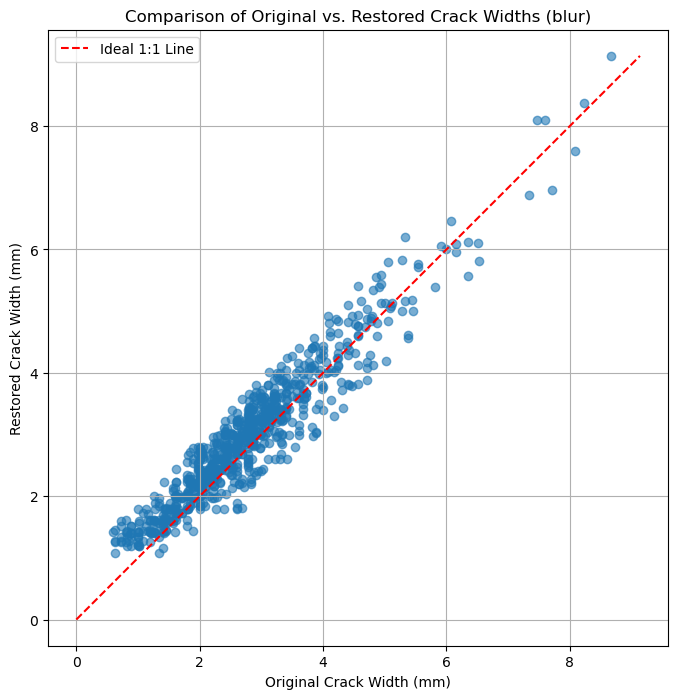

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Load the data from your SHADOW analysis ---
df = pd.read_csv("blur.csv")

# --- 2. The rest of your plotting code is the same ---
# Drop rows where the measurement might have failed, for a clean plot
df_cleaned = df.dropna(subset=['clean_width_mm', 'restored_width_mm'])
df_cleaned = df_cleaned[df_cleaned['restored_width_mm'] > 0]

# Create the plot
plt.figure(figsize=(8, 8))
plt.scatter(df_cleaned['clean_width_mm'], df_cleaned['restored_width_mm'], alpha=0.6)
# Add a red 1:1 line for perfect correlation
max_val = max(df_cleaned['clean_width_mm'].max(), df_cleaned['restored_width_mm'].max())
plt.plot([0, max_val], [0, max_val], 'r--', label='Ideal 1:1 Line')

plt.xlabel("Original Crack Width (mm)")
plt.ylabel("Restored Crack Width (mm)")
plt.title("Comparison of Original vs. Restored Crack Widths (blur)")
plt.grid(True)
plt.legend()
plt.axis('equal')
plt.show()